# Project Part 2
## Question 1
### Imports and data wrangling


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq
from scipy.optimize import least_squares
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [2]:
swaption = pd.read_excel("./data/IR Data.xlsx",     # load swaption pricing
                sheet_name = 'Swaption',
                header=2)
swaption[swaption.columns[2:]] /= 100   # scale percentage IV to fraction
fsr = pd.read_csv('./data/fsr.csv')\
        .rename(columns={'start': "Expiry", 
                         'tenor': "Tenor"}) # load forward swap rates
ois = pd.read_csv('./data/irs.csv')     # load discounting curve
df_irs_fwd = pd.read_csv('./data/irs_fwd.csv')     # load discounting curve

In [3]:
df_irs_fwd

,Expiry,Tenor,f_irs,f_ois
0,2,10,0.039634,0.005058
1,8,10,0.048711,0.005972


In [4]:
# fsr.head(2)

In [5]:
# ois.head(2)

In [6]:
bps = [-.0200, -.0150, -.0100, -.0050, -.0025, 0, .0025, .0050, .0100, .0150, .0200]
df_strike = swaption.copy()
for i,forward_rate in enumerate(fsr.f_irs):
    for j, bp in enumerate(bps):
        df_strike.iloc[i,j+2] = forward_rate + bp

df_strike.head(2)

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,0.011922,0.016922,0.021922,0.026922,0.029422,0.031922,0.034422,0.036922,0.041922,0.046922,0.051922
1,1Y,2Y,0.013217,0.018217,0.023217,0.028217,0.030717,0.033217,0.035717,0.038217,0.043217,0.048217,0.053217


In [7]:
# ATM Black IV
swaption.head(2)

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,0.9157,0.6203,0.4413,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297
1,1Y,2Y,0.8327,0.6124,0.4657,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523


## Valuing a swaption
$$
\text{Payer Swaption} = \left[ P_{n+1,N}(T) \left( S_{n,N}(T) - K \right) \right]^+
$$
$$
\text{Receiver Swaption} = \left[ P_{n+1,N}(T) \left( K - S_{n,N}(T) \right) \right]^+
$$

Using PVBP as risk neutral numeraire, and applying Black normal model
$$
\begin{aligned}
\frac{V^{\text{payer}}_{n,N} (0)}{P_{n+1,N} (0)} &= \mathbb{E}^{n+1,N} \left[ \frac{V^{\text{payer}}_{n,N} (T_n)}{P_{n+1,N} (T_n)} \right] \\
\Rightarrow V^{\text{payer}}_{n,N} (0) &= P_{n+1,N} (0) \mathbb{E}^{n+1,N} \left[ (S_{n,N} (T) - K)^+ \right] \\ \\
V^{\text{payer}}_{n,N} (0) = & P_{n+1,N} (0) \left[ S_{n,N} (0) \Phi(d_1) - K \Phi(d_2)  \right]
\end{aligned}
$$
1. get 

### Displaced-Diffusion Model
Assumes a linear combination of Geometric and Arithmetic Brownian Process to model swap rates

In [8]:
def pvbp(expiry, tenor):
    # Calculate PVBP
    """
    Return PVBP for a period from expiry to end of tenor in years t should be >= 0.5
    assumed to be semi-annual payments collateralised in over night market
    """
    t = expiry
    T = expiry + tenor
    delta_t = 0.5   
    sum_df = (ois.loc[(ois.years > t) & (ois.years <= T)]).ois_df.sum()

    return delta_t * sum_df
    
def black76_pay(F, K, expiry, tenor, sigma):
    """
    Return value of payer swaption via Black Normal model and multiplied by PVBP
    parameters
        F: forward par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma: annual vol
    """
    t = expiry
    d_1 = (np.log(F/K) + (1/2) * (sigma**2) * t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    black_option = F * norm.cdf(d_1) - K * norm.cdf(d_2)
    return pvbp(expiry,tenor) * black_option
    
def black76_rec(F, K, expiry, tenor, sigma):
    """
    Return value of receiver swaption via Black Normal model and multiplied by PVBP
    parameters
        F: Forward par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma: annual vol
    """
    t = expiry
    d_1 = (np.log(F/K) + (1/2) * (sigma**2) * t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    black_option = K * norm.cdf(-d_2) - F * norm.cdf(-d_1)
    return pvbp(expiry,tenor) * black_option

def implied_black_volatility(F, K, expiry, tenor, model_price, tol=1e-6):
    """
    Return implied vol for a black normal option
    parameters
        F: Forward par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
    """
    sigma_min, sigma_max = -1e-6, 5.0
    if F > K:
        fn_black_normal = black76_rec
    else:
        fn_black_normal = black76_pay
    
    err = lambda x: fn_black_normal(F, K, expiry, tenor, x) - model_price
    
    return brentq(err, sigma_min, sigma_max, xtol=tol)

def dd_valuation(F, K, expiry, tenor, sigma_atm, beta):
    """
    Return value of receiver swaption  via Displaced Diffusion model and multiplied by PVBP. 
    Use black price function depending on F < K, then OTM payer else OTM receiever
    parameters
        F: forwar par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma: ATM vol for this expiry
        beta: DD beta
    """
    if F > K:
        fn_black_normal = black76_rec
    else:
        fn_black_normal = black76_pay
        
    return fn_black_normal(F/beta, K + ((1-beta)/beta)*F, expiry, tenor, sigma_atm * beta)

def fn_dd_err(beta, F, arr_K, arr_sigma, expiry, tenor, sigma_atm):
    """
    Return error term for DD and black normal vols. compute dd price and get black normal vol based on price. 
    Return the difference in computed vol against the given implied vol
    parameters
        beta: DD beta
        F: forward par swap rate given by forward IRS
        K: list strikes of swaption for the given expiry
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma_atm: ATM vol for this expiry
    """
    model_vols = []

    for K, sigma_implied in zip(arr_K, arr_sigma):
        dd_price = dd_valuation(F, K, expiry, tenor, sigma_atm, beta)
        sigma_model = implied_black_volatility(F, K, expiry, tenor, dd_price)
        # save result
        model_vols.append(sigma_model)

    return np.array(model_vols) - arr_sigma

In [9]:
df_strike.head(2)

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,0.011922,0.016922,0.021922,0.026922,0.029422,0.031922,0.034422,0.036922,0.041922,0.046922,0.051922
1,1Y,2Y,0.013217,0.018217,0.023217,0.028217,0.030717,0.033217,0.035717,0.038217,0.043217,0.048217,0.053217


In [10]:
swaption

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,0.91570,0.62030,0.44130,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297
1,1Y,2Y,0.83270,0.61240,0.46570,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523
2,1Y,3Y,0.73920,0.56870,0.44770,0.35745,0.32317,0.2978,0.2829,0.2780,0.2877,0.30725,0.32833
3,1Y,5Y,0.55190,0.44640,0.36510,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165
4,1Y,10Y,0.41180,0.35040,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355
5,5Y,1Y,0.67800,0.49090,0.38400,0.31485,0.29060,0.2726,0.2604,0.2532,0.2494,0.25320,0.25980
6,5Y,2Y,0.57880,0.46410,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.26540,0.26760
7,5Y,3Y,0.53430,0.44440,0.38180,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.26200,0.26150
8,5Y,5Y,0.41990,0.36524,0.32326,0.29005,0.27677,0.2660,0.2573,0.2502,0.2406,0.23570,0.23400
9,5Y,10Y,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.22490,0.22250


##### Calibrating Beta
- One beta is calculated for one expiry and tenor, across multiple strikes. DD model is used to have the least errors against the implied vols for all given strikes.
- To calibrate for beta, use a fitting algorithm to solve for a beta that will reduce the objective function $\sigma_{implied} = \sigma_{black}$, where $\sigma_{dd} = \sigma_{atm}\beta$

steps:
1. calculate DD model swaption price
2. calculate $\sigma_{black}$ based on DD model swaption price
3. conduct beta search by reducing error given by $\sigma_{implied} - \sigma_{black}$ by changing DD $\beta$

In [11]:
fsr.head(1)

,Expiry,Tenor,f_irs,f_ois
0,1,1,0.031922,0.003501


In [12]:
ls_beta =[]

for row_idx in range(len(fsr)):
  F = fsr['f_irs'][row_idx]
  expiry = fsr['Expiry'][row_idx]
  tenor = fsr['Tenor'][row_idx]
  arr_K = df_strike.iloc[row_idx][2:].values.astype('float')
  arr_sigma = swaption.iloc[row_idx][2:].values.astype('float')
  sigma_atm = arr_sigma[5]
  beta_guess = 0.7

  res = least_squares(fn_dd_err, 
                beta_guess, 
                bounds=(-1e-6,1), 
              args=(F, 
                    arr_K, 
                    arr_sigma, 
                    expiry,
                    tenor,
                    sigma_atm))
  ls_beta.append(res.x[0])

  beta_guess = res

fsr['beta'] = ls_beta
fsr.head(2)

,Expiry,Tenor,f_irs,f_ois,beta
0,1,1,0.031922,0.003501,-9.999934e-07
1,1,2,0.033217,0.003526,-9.959427e-07


#### Calibrated Displaced Diffusion $\beta \ \sigma$

In [13]:
sorted_index = ['1Y', '5Y', '10Y']
sorted_cols =  ['1Y', '2Y', '3Y', '5Y', '10Y']
# tabulating ATM sigma
df_swaption_sigma = swaption.pivot(index='Expiry',
                                columns='Tenor', 
                                values='ATM')\
                            .reindex(index=sorted_index,
                                    columns=sorted_cols)
# tabulating calibrated betas
df_swaption_beta = fsr.pivot(index='Expiry',
                                columns='Tenor', 
                                values='beta')
df_swaption_beta.index = pd.Index(sorted_index, name="Expiry")
df_swaption_beta.columns = pd.Index(sorted_cols, name="Tenor")

In [14]:
df_swaption_sigma

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,0.2250,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.2660,0.2451
10Y,0.2854,0.2928,0.2940,0.2674,0.2437


In [15]:
df_swaption_beta

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,-9.999934e-07,-9.959427e-07,-8.963219e-07,-9.999771e-07,-7.543397e-07
5Y,-9.896596e-07,-9.999753e-07,-9.956291e-07,-9.994220e-07,5.002995e-02
10Y,-9.999337e-07,-9.785647e-07,-2.786882e-07,-9.996158e-07,1.077358e-06


In [16]:
# create function to compute dd vols
def dd_vols(row_idx):
    """
    Returns dataframe of Black normal IV based on row index and 
    """
    F = fsr['f_irs'][row_idx]
    expiry = fsr['Expiry'][row_idx]
    tenor = fsr['Tenor'][row_idx]
    arr_K = df_strike.iloc[row_idx][2:].values.astype('float')
    arr_sigma = swaption.iloc[row_idx][2:].values.astype('float')
    sigma_atm = arr_sigma[5]
    
    ls_dd_vol = []
    beta = fsr.iloc[row_idx]['beta']

    for K in arr_K:
        dd_price = dd_valuation(F, K, expiry, tenor, sigma_atm, beta)
        sigma_model = implied_black_volatility(F, K, expiry, tenor, dd_price)
        ls_dd_vol.append(sigma_model)
    df_dd_vol = pd.DataFrame(ls_dd_vol, columns=["DD calibrated vol"])

    return df_dd_vol

# Question 2
## SABR model

Assumes stochastic variance

In [17]:
def SABR(F, K, T, alpha, beta, rho, nu):
    """
    return black sigma using SABR model
    """
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T, beta=0.9) -> float:
    """
    Return total squared error between estimated (using parameters in x) and actual given(vols) sigmas
    float

    Parameters:
        x: list of SABR parameters with alpha, rho, nu,
        strikes: K,
        vols: list of market implied volatility,
        F: par swap or swap futures rate adjusted for T 
        T: years to expiry

    Return:
        total error computed from list of vol provided
    """
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    
    return err

ls_alpha =[]
ls_rho =[]
ls_nu =[]

for row_idx in range(len(fsr)):
    F = fsr['f_irs'][row_idx]
    expiry = fsr['Expiry'][row_idx]
    tenor = fsr['Tenor'][row_idx]
    arr_K = df_strike.iloc[row_idx][2:].values.astype('float')
    arr_sigma = swaption.iloc[row_idx][2:].values.astype('float')
    sigma_atm = arr_sigma[5]
    # param search
    initialGuess = [.02,-0.5, 1.05] # need to make second value -ve for rho and positive more than 1 for nu
    res = least_squares(lambda x: sabrcalibration(x, arr_K, arr_sigma, F, expiry), initialGuess, max_nfev=32_000)
    alpha, rho, nu = res.x
    ls_alpha.append(alpha)
    ls_rho.append(rho)
    ls_nu.append(nu)

fsr['alpha'] = ls_alpha
fsr['rho'] = ls_rho
fsr['nu'] = ls_nu
fsr.head(2)

,Expiry,Tenor,f_irs,f_ois,beta,alpha,rho,nu
0,1,1,0.031922,0.003501,-9.999934e-07,0.139080,-0.632309,2.041879
1,1,2,0.033217,0.003526,-9.959427e-07,0.184666,-0.524760,1.674725


In [18]:
# tabulating calibrated alphas, rho, nu
df_swaption_alpha = fsr.pivot(index='Expiry',
                                columns='Tenor', 
                                values='alpha')
df_swaption_alpha.index = pd.Index(sorted_index, name="Expiry")
df_swaption_alpha.columns = pd.Index(sorted_cols, name="Tenor")

df_swaption_rho = fsr.pivot(index='Expiry',
                                columns='Tenor', 
                                values='rho')
df_swaption_rho.index = pd.Index(sorted_index, name="Expiry")
df_swaption_rho.columns = pd.Index(sorted_cols, name="Tenor")

df_swaption_nu = fsr.pivot(index='Expiry',
                                columns='Tenor', 
                                values='nu')
df_swaption_nu.index = pd.Index(sorted_index, name="Expiry")
df_swaption_nu.columns = pd.Index(sorted_cols, name="Tenor")


#### Calibrated SABR $\alpha \ \beta \ \nu$

In [19]:
df_swaption_alpha

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,0.139080,0.184666,0.196861,0.178061,0.169966
5Y,0.166618,0.199534,0.210347,0.190249,0.174825
10Y,0.178282,0.196314,0.208249,0.201578,0.178236


In [20]:
df_swaption_rho

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,-0.632309,-0.524760,-0.482647,-0.414394,-0.255183
5Y,-0.585668,-0.547030,-0.549811,-0.506845,-0.415868
10Y,-0.548441,-0.547537,-0.553581,-0.563593,-0.500916


In [21]:
df_swaption_nu

Tenor,1Y,2Y,3Y,5Y,10Y
Expiry,,,,,
1Y,2.041879,1.674725,1.436639,1.064190,0.792161
5Y,1.340428,1.062007,0.936805,0.674523,0.511207
10Y,1.010309,0.928642,0.871680,0.722494,0.587110


In [22]:
def sabr_vols(row_idx, beta=0.9):
    """
    Return SABR vols as a Dataframe
    """
    F = fsr['f_irs'][row_idx]
    expiry = fsr['Expiry'][row_idx]
    arr_K = df_strike.iloc[row_idx][2:].values.astype('float')
    
    ls_sabr_vol = []
    alpha = fsr.iloc[row_idx]['alpha']
    rho = fsr.iloc[row_idx]['rho']
    nu = fsr.iloc[row_idx]['nu']

    for K in arr_K:
        sabr_vol = SABR(F, K,expiry,alpha,beta,rho,nu)
        ls_sabr_vol.append(sabr_vol)
    df_sabr_vol = pd.DataFrame(ls_sabr_vol, columns=["sabr calibrated vol"])

    return df_sabr_vol

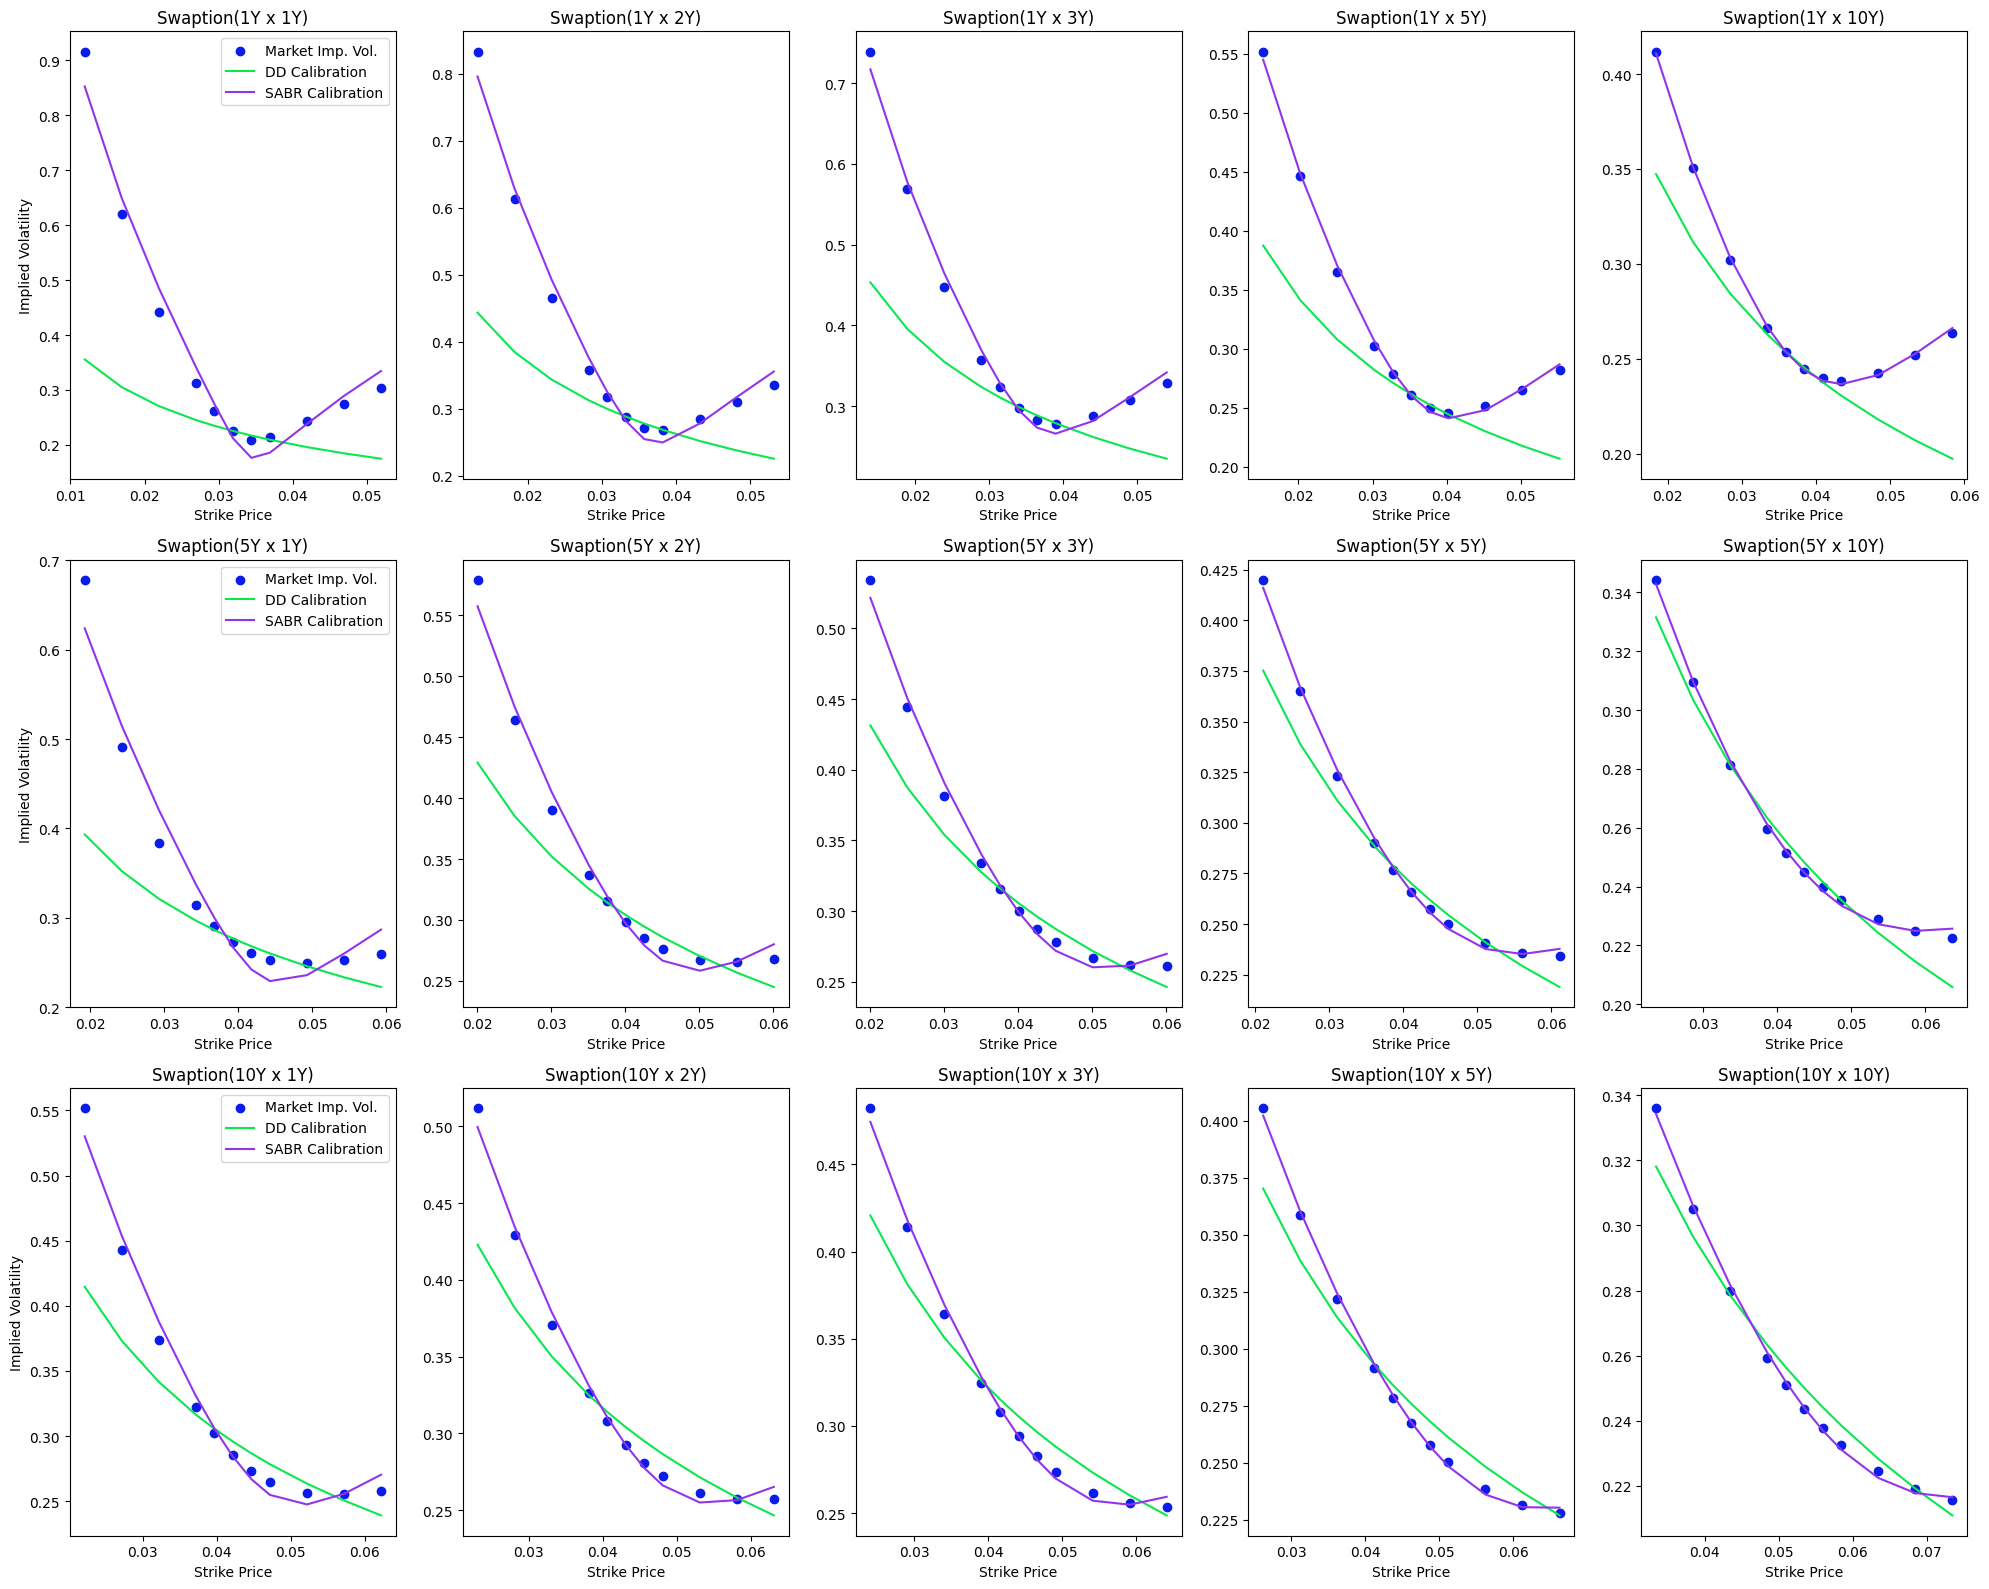

In [23]:
plt.figure(figsize=(20, 16))
for row_idx in range(len(swaption)):
    plt.subplot(3, 5, row_idx + 1)
    
    # Market vols
    plt.scatter(df_strike.iloc[row_idx, 2:], swaption.iloc[row_idx, 2:], label='Market Imp. Vol.', color="#091ce8")
    # DD model vols
    plt.plot(df_strike.iloc[row_idx, 2:], dd_vols(row_idx), label='DD Calibration', color="#09e850")
    # SABR model vols
    plt.plot(df_strike.iloc[row_idx, 2:], sabr_vols(row_idx), label='SABR Calibration', color="#9234eb")
    
    plt.title(f"Swaption({swaption['Expiry'][row_idx]} x {swaption['Tenor'][row_idx]})")
    plt.xlabel("Strike Price")
    
    # Only set y-label for the first column
    if row_idx % 5 == 0:
        plt.ylabel("Implied Volatility")
        plt.legend()

plt.tight_layout()
plt.show()


#### validate the low DD Beta 
Beta values are very low (practically 0) implying a more convex shape of the volatility smile. Indeed we see that the volatility smile is very convex and DD is too rigid to fit the market vols.

Closest match is for 5X10 option

#### SABR flexibility
SABR has muchmore degrees of freedom than DD so can fit the convexity of market pricing much better

# Question 3


In [24]:
ls_strikes = [.01*i for i in range(1,9)]

# interpolate DD betas
beta_2x10 = (df_swaption_beta['10Y'][1]-df_swaption_beta['10Y'][0])/4 + df_swaption_beta['10Y'][0]
beta_8x10 = (df_swaption_beta['10Y'][2]-df_swaption_beta['10Y'][1])/5*3 + df_swaption_beta['10Y'][1]
# interpolate DD sigmas
sigma_2x10 = (df_swaption_sigma['10Y'][1]-df_swaption_sigma['10Y'][0])/4 + df_swaption_sigma['10Y'][0]
sigma_8x10 = (df_swaption_sigma['10Y'][2]-df_swaption_sigma['10Y'][1])/5*3 + df_swaption_sigma['10Y'][1]

# interpolate sabr alphas
alpha_2x10 = (df_swaption_alpha['10Y'][1]-df_swaption_alpha['10Y'][0])/4 + df_swaption_alpha['10Y'][0]
alpha_8x10 = (df_swaption_alpha['10Y'][2]-df_swaption_alpha['10Y'][1])/5*3 + df_swaption_alpha['10Y'][1]
# interpolate sabr rho
rho_2x10 = (df_swaption_rho['10Y'][1]-df_swaption_rho['10Y'][0])/4 + df_swaption_rho['10Y'][0]
rho_8x10 = (df_swaption_rho['10Y'][2]-df_swaption_rho['10Y'][1])/5*3 + df_swaption_rho['10Y'][1]
# interpolate sabr nu
nu_2x10 = (df_swaption_nu['10Y'][1]-df_swaption_nu['10Y'][0])/4 + df_swaption_nu['10Y'][0]
nu_8x10 = (df_swaption_nu['10Y'][2]-df_swaption_nu['10Y'][1])/5*3 + df_swaption_nu['10Y'][1]

### 2x10 payer swap


In [25]:
expiry = 2
tenor = 10
F = df_irs_fwd.loc[(df_irs_fwd.Expiry==expiry) & 
                   (df_irs_fwd.Tenor==tenor)]['f_irs']\
            .values[0]
sigma_atm = sigma_2x10
beta = beta_2x10

ls_dd_pricing = []
ls_sabr_pricing = []

for K in ls_strikes:
    # dd valuation
    dd_pricing = black76_pay(F/beta, K + (1-beta)/beta*F, expiry, tenor, sigma_atm * beta)
    ls_dd_pricing.append(dd_pricing)
    # sabr valuation
    sigma_sabr = SABR(F, K, expiry, alpha_2x10, beta=0.9, rho=rho_2x10, nu=nu_2x10)
    sabr_pricing = black76_pay(F, K, expiry, tenor, sigma_sabr)
    ls_sabr_pricing.append(sabr_pricing)
    
pay_2x10 = pd.DataFrame({"Strikes": ls_strikes,
                        "Displaced Diffusion": ls_dd_pricing,
                        "SABR": ls_sabr_pricing})
pay_2x10

,Strikes,Displaced Diffusion,SABR
0,0.01,0.288138,0.289686
1,0.02,0.194938,0.198398
2,0.03,0.112330,0.115126
3,0.04,0.051343,0.051959
4,0.05,0.017359,0.021486
5,0.06,0.004100,0.011053
6,0.07,0.000649,0.006970
7,0.08,0.000067,0.004978


#### 8x10 receiver swap

In [26]:
expiry = 8
tenor = 10
F = df_irs_fwd.loc[(df_irs_fwd.Expiry==expiry) & 
                   (df_irs_fwd.Tenor==tenor)]['f_irs']\
            .values[0]
sigma_atm = sigma_8x10
beta = beta_8x10

ls_dd_pricing = []
ls_sabr_pricing = []

for K in ls_strikes:
    # dd valuation
    dd_pricing = black76_rec(F/beta, K + (1-beta)/beta*F, expiry, tenor, sigma_atm * beta)
    ls_dd_pricing.append(dd_pricing)
    # sabr valuation
    sigma_sabr = SABR(F, K, expiry, alpha_8x10, beta=0.9, rho=rho_8x10, nu=nu_8x10)
    sabr_pricing = black76_rec(F, K, expiry, tenor, sigma_sabr)
    ls_sabr_pricing.append(sabr_pricing)
rec_8x10 = pd.DataFrame({"Strikes": ls_strikes,
                        "Displaced Diffusion": ls_dd_pricing,
                        "SABR": ls_sabr_pricing})
rec_8x10

,Strikes,Displaced Diffusion,SABR
0,0.01,0.019067,0.019873
1,0.02,0.033985,0.039101
2,0.03,0.056712,0.061559
3,0.04,0.089009,0.090292
4,0.05,0.132036,0.130129
5,0.06,0.186079,0.186250
6,0.07,0.250491,0.258138
7,0.08,0.323863,0.339878


---

#### Export calibrated SABR params

In [27]:
fsr.to_csv('./data/sabr_params.csv', index=False)